# GPU vs CPU (single core) benchmark on MNIST
## System 
- CPU: Intel Core i7-8700K @ 3.70GHz
- GPU: NVIDIA GeForce GTX 1080 8GB
- RAM: 32GB DDR4 3200MHz

In [4]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras import backend as K

## Data

In [5]:
#data preprocessing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
x_train=x_train.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

In [6]:
#labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

## GPU

In [13]:
#build model

num_filter=32
num_dense=512
drop_dense=0.7
ac='relu'
learningrate=0.001

model = Sequential()

model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

model.add(Flatten())                        
model.add(Dense(num_dense, activation=ac))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))

adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_15 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_16 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

In [14]:
# with GPU (the default in my setup)
for i in range(7):
    k=8*2**i
    print("batch size "+str(k))
    model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

batch size 8
7500/7500 [==============================] - 48s 6ms/step - loss: 0.2238 - accuracy: 0.9338 - val_loss: 0.0365 - val_accuracy: 0.9872
batch size 16
3750/3750 [==============================] - 29s 8ms/step - loss: 0.0723 - accuracy: 0.9787 - val_loss: 0.0362 - val_accuracy: 0.9888
batch size 32
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0405 - accuracy: 0.9882 - val_loss: 0.0207 - val_accuracy: 0.9928
batch size 64
938/938 [==============================] - 8s 9ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0167 - val_accuracy: 0.9945
batch size 128
469/469 [==============================] - 6s 12ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.0152 - val_accuracy: 0.9953
batch size 256
235/235 [==============================] - 4s 18ms/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.0136 - val_accuracy: 0.9957
batch size 512
118/118 [==============================] - 4s 30ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0

## CPU

In [15]:
# with CPU only: (tensorflow tries to use all cores available)
with tf.device("/cpu:0"):
    model = Sequential()

    model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

    model.add(Flatten())                        
    model.add(Dense(num_dense, activation=ac))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(10, activation='softmax'))

    adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)
    model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_20 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_21 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

In [17]:
with tf.device("/cpu:0"):
    for i in range(7):
        k=8*2**i
        print("batch size "+str(k))
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

batch size 8
7500/7500 [==============================] - 157s 21ms/step - loss: 0.1211 - accuracy: 0.9671 - val_loss: 0.0222 - val_accuracy: 0.9927
batch size 16
3750/3750 [==============================] - 121s 32ms/step - loss: 0.0462 - accuracy: 0.9865 - val_loss: 0.0284 - val_accuracy: 0.9920
batch size 32
1875/1875 [==============================] - 106s 57ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.0278 - val_accuracy: 0.9935
batch size 64
938/938 [==============================] - 94s 101ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.0207 - val_accuracy: 0.9946
batch size 128
469/469 [==============================] - 82s 175ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0155 - val_accuracy: 0.9951
batch size 256
235/235 [==============================] - 77s 326ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0162 - val_accuracy: 0.9953
batch size 512
118/118 [==============================] - 75s 633ms/step - loss: 0.0054 - accuracy: 0.998

## Comparision

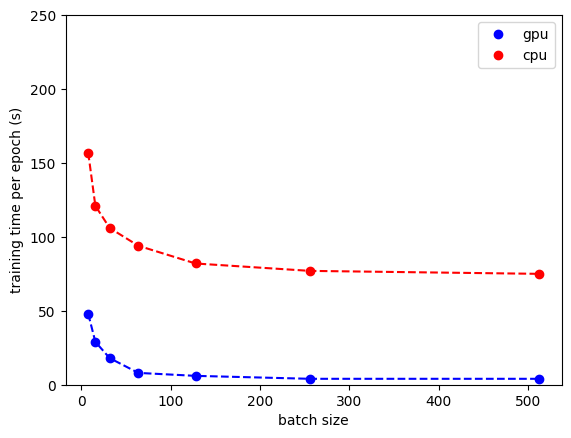

In [20]:
# plot the comparison
batch_sizes=[8,16,32,64,128,256,512]

# extracted from the output of the above code
gpu_list=[48, 29, 18, 8, 6, 4 , 4]
cpu_list=[157, 121, 106, 94, 82, 77, 75]

plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,250])
plt.savefig('../Documentation/CPUvsGPU.png') 
plt.show()